# Implemention of the Behavior Pattern Method
nach 
Diamantini, C., Genga, L. & Potena, D. Behavioral process mining for unstructured processes. J Intell Inf Syst 47, 5–32 (2016). https://doi.org/10.1007/s10844-016-0394-7

In [19]:
import pm4py
from pm4py.objects.log.obj import EventLog
from pm4py.objects.log.obj import Event
from pm4py.objects.log.obj import Trace
from pm4py.objects.petri_net.obj import PetriNet
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.objects.petri_net.exporter import exporter as pnml_exporter
from pm4py.objects.petri_net.importer import importer as pnml_importer

import os
import json
from src.helper import HiddenPrints 
from tqdm import tqdm

## Import XES File
from https://pm4py.fit.fraunhofer.de/documentation#item-impoort-xes

Event Log, und Trace: 
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.log.html?  highlight=objects%20log%20obj%20eventlog#pm4py.objects.log.obj.EventLog

EventLog[] => Trace  
EventLog[][] => Event of Trace

#### Ist eine Bereiningung des Event Logs nötigt auf => Aktivitäten 
Der event Log zeigt die Events nicht die ausgeführten Aktivitäten, wirkt sich das aus auf die Generierung des Petri Net und Alignemt, weil die Events verwendet werden nicht die Aktivitäten.

In [20]:
path = "datasets/02_TestCompletedFFF_onlyTaskItems_simpleFilter.xes"
# path = "datasets/01_TestCompletedFFF_IDtoString_removeTransitionClassifier.xes"
log = xes_importer.apply(path)
log = pm4py.filter_case_size(log, 0, 300)

parsing log, completed traces :: 100%|██████████| 81/81 [00:01<00:00, 80.40it/s]


In [21]:
# Event dict Eigenschaften 
print(log[0][0])

{'lifecycle:transition': 'start', 'time:timestamp': datetime.datetime(2019, 11, 20, 13, 57, 10, tzinfo=datetime.timezone(datetime.timedelta(seconds=3600))), 'cdb_process_id': 'P00062587', 'concept:instance': 326309, 'concept:name': 'Product Modification Responsible is correctly assigned?', 'description': "The task has been completed.  It's OK", 'division': 'UNDEFINED', 'msgtype': 'DONE', 'org:resource': '1079b397-2699-11ec-8124-0050568b0d8f', 'task_id': 'T00010248'}


BoxPLot, um Size Verteilung zu sehen und Ausreißer zu identifizieren.
Ziel dadurch das Modell zu vereinfachen und Zeit in dr Berechnung der Alignment zu sparen: 

Der BoxPLot zeigt anhand der Trace Sizes 2 Ausreißer an: >800 und >300


121.92405063291139


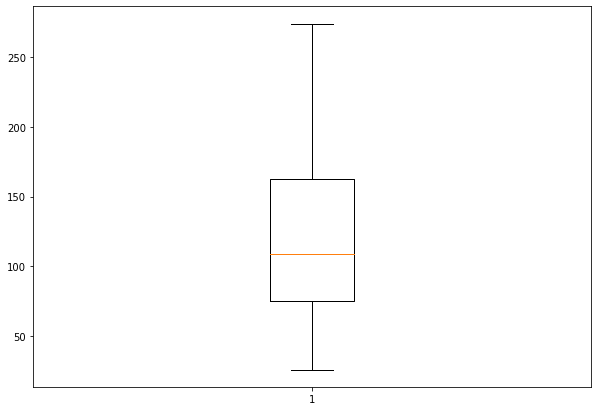

In [22]:
import matplotlib.pyplot as plt

# Creating dataset
data = list()
summe= 0
for trace in log:
    trace_len = len(trace)
    data.append(trace_len)
    summe += trace_len

print(summe/len(data))

fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(data)
 
# show plot
plt.show()

In [23]:
from src.log_classifier_helper import addDivisionClassifier


## Get Real Welt Modell as Petri Net 
with Inductive Miner Infrequent for Casual Relation  
from https://pm4py.fit.fraunhofer.de/documentation#item-3-2  
Parameters: https://pm4py.fit.fraunhofer.de/static/assets/api/2.1.0/pm4py.algo.discovery.inductive.html?highlight=parameters%20activity_key#pm4py.algo.discovery.inductive.parameters.Parameters

The noise threshold (between 0.0 and 1.0) to be used. Default: 0.2

Dauer ca. 2min

### Adding Orga Unit (und lifecycleTransition (?)) 
Ich verwende Division, weil Ressource ein zu komplexes Modell liefern würde und die Ressourcen verschlüsselt. Daher schwierig Aussagekraft abzuleiten. Aussage kräftiger, wenn Divisionen angeschaut. 

Probleme mit dem Discovery Modell mit dem zusammengesetzten Classifier aus der Division und Name.

Integration des lifecycle dauert die Generieung eins Petrinetzes sehr lange.

Division funktioniert

Division Lifecycle => bricht ab ohne fehler

Ressource funktioinert nicht! => Algorithmus bricht ab ohne Fehler-

In [24]:
##### Import Section

petri_net_division_name_Path = os.path.join("output/petri_net_division_name.pnml")
petri_net_name_Path = os.path.join("output/petri_net_name.pnml")
# Change on Classifier Change
path = petri_net_division_name_Path

net, initial_marking, final_marking = pnml_importer.apply(path)



In [25]:
std_classifier = "concept:name"
customClassifierDivision = "customClassifierDivision"
customClassifierRessource = "customClassifierRessource"
# Change on Classifier Change
classifier=customClassifierDivision
if(classifier != std_classifier):
    addDivisionClassifier(log, customClassifierDivision)

ccStdAlignmentPath = 'output/custom_cost_alignment_name_classifier/'
ccDivisionAlignmentPath = 'output/custom_cost_alignment_division_name_classifier/'
ccRessource = 'Not existing'
# Change on Classifier Change
alignmentPathFolder = ccDivisionAlignmentPath


## Auswertung der Kanten 
Aus dem Event Log wurde mithilfe des Inductive Miner Infrequnent (vgl. Leemans at al 2014) ein Real welt Modell erstellt. less frequent behavior, loops ect. finden (vgl. Dimanatini)  
Output Petrie Netz. Ergebnis dient zur Grundlage für für die Casual Rel Eigenschaft und im folgende für das Instance ordering, d.h. Einfluss die Qualitäten der Kanten Bindungen der Instance Graphen.


Zwei Ansätze ausprobiert:  
Event Name Only - nicht nac methode, würde in nachträgliches einfügen der ressource oder Division benötigen.
Custom Classifier Division - mit Diviison nach methode
Custom Classifiier Ressource - Algorithmus hat sich nicht beendet, unbekannte Ursache

In [26]:
print('Transitionen: ', len(net.transitions))
print('Silent Transitionen: ', len({trans for trans in net.transitions if trans.label == None}))
print('Silent Transitionen: ', len({trans for trans in net.transitions if trans.label != None}))

Transitionen:  560
Silent Transitionen:  406
Silent Transitionen:  154


Zur Auswertung der petri Netzes Statistik Auswertung des Instance Ordering.
Meine Implementation des ein Instance Ordering Tupel existiert, wenn zwei Transitionen über eine Stelle Verbunden sind.
Aussage über Qualität möglich.

Wie hoch ist der Anteil an silent Transition; Transitionen,die keine Entsprechung im trace haben
Häufigkeit Silent Transitionen, Silent Trans und Aktivitäten und zwischen Aktivitäten:

Mit Division Classifier:  
Transitionen:  560  
Silent Transitionen:  406  
Silent Transitionen:  154  

Ohne Custom Classifier:  
Transitionen:  332  
Silent Transitionen:  226  
Silent Transitionen:  106  

Kritik an Statistik: 
einige Silent Transitionen stehen für tauJoin und Tausplit => Verhaltensrelevant, herausnehmen? weiß zu wenig




In [27]:
anteilSilent = round(406 / 560 *100, 2)
anteilActivities = round(154 / 560  *100, 2)

print(anteilSilent, anteilActivities)

anteilSilent = round(226 / 332 *100, 2)
anteilActivities = round(106 / 332  *100, 2)

print(anteilSilent, anteilActivities)

72.5 27.5
68.07 31.93


Wir stellen fest, dass der Anteil der Silent Transitionen überwiegt im Vergleich zu den mit Aktivitäten.


## From Petri Netz zu Instance Ordering  

### Casual Relation:

Zwei events i, j haben eine Causal Relation, wenn i erst abgeschlossen werden muss, damit j ausgeführt werden kann.  
Das Petri Netz ist Modell und die CR Relation, bzw. die Grundlage davon. 

Es sind in der relation keine Silent Transitionen aus dem 
Petri Netz enthalten!

### Instance Ordering: 

i, j und k sind Events; i<k<j  
Es besteht eine CR Relation zwischen i und j;  
und  
(Es darf keine CR Relation zwischen i und k:  
Oder  
Es darf keine CR Relation zwischen k und j geben;)  

Bezug zum Petri Netz, welches als Grundlage für die CR Relation verwendet wird:  
Ein Event ist im Petri Netz eine Transition; der Aktivitäten Name kann über Label aufgerufen werden.
Im Ordering sid keine silent Transitionen aus dem Petri Net enthalten

Siehe hierzu auch  
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.petri_net.html?highlight=petrinet#pm4py.objects.petri_net.obj.PetriNet  
https://pm4py.fit.fraunhofer.de/documentation#item-4-2

In [28]:
from src.casual_releation import calculateCR

In [29]:
cr = calculateCR(net)
print('# Casual Relations', len(cr))

""" 
Depth ist der Wert wie viele Aktivitäten zwischen dem Casual Predecessor und dem Casual Successor
Starts at -1 (Überspringt sich selbst als predecessor)), -1 is an self-loop, 0 fullFills an instanceOrdering characteristic    
"""
instanceOrdering = {(source,target) for (source,target,depth) in cr if(depth < 1)}
print('# Direkte Nachfolger mit der Instance Ordering Eigenschaft', len(instanceOrdering))
print('# Nachfolger Tiefe 1', len({(source,target) for (source,target,depth) in cr if(depth == 1)}))
print('# Nachfolger Tiefe 2', len({(source,target) for (source,target,depth) in cr if(depth == 2)}))
print('# Nachfolger Tiefe 3', len({(source,target) for (source,target,depth) in cr if(depth == 3)}))
print('Min Tiefe: ', min(cr,key=lambda cr: cr[2])[2]) # -1 => self loop exists
print('Maximum Tiefe: ', max(cr,key=lambda cr: cr[2])[2])

100%|██████████| 560/560 [00:00<00:00, 5965.69it/s]

# Casual Relations 12815
# Direkte Nachfolger mit der Instance Ordering Eigenschaft 2579
# Nachfolger Tiefe 1 3428
# Nachfolger Tiefe 2 3903
# Nachfolger Tiefe 3 1394
Min Tiefe:  -1
Maximum Tiefe:  10


### Problem My Instance ordering Implementation
![alt text](assets/my_implementation_instance_ordering_problem1.png "Title")
![alt text](assets/my_implementation_instance_ordering_problem2.png "Title")

## Instance Graphen

Werden aus dem Instance Ordering, welches  aus der vorangegangen Methode erhalten haben.
Es wird nun nach den Vorgaben aus den Wissenschaftlichen Beitrag ein Instanz Graph erstellt.  
Ein Instance Graph wird ein Tupel aus Knoten, edges und einen Dictionary sein, welches ein Mapping zwischen dem den Knoten und dem entsprechenden Log Event darstellt.

Referenzen zum Event Log
https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.objects.log.html?highlight=eventlog#pm4py.objects.log.obj.EventLog



In [30]:
## instance_graph.py
from src.instance_graph import genInstanceGraph
from src.instance_graph import buildingInstanceGraphsFromLog

### Generiere alle Instanz Graphen ohne Reparatur

In [31]:
instanceGraphs = list()
cr = calculateCR(net)
for instance in log:
    nodes, edges, nodeEventDict = genInstanceGraph(instance, cr, classifier)
    instanceGraphs.append((nodes, edges, nodeEventDict))


100%|██████████| 560/560 [00:00<00:00, 6208.31it/s]


## Repair irreguläre Instanz Graphen 

### PM4Py Alignment: Kosten der Abweichen benutzen zum aufspüren irregulärer Traces
https://pm4py.fit.fraunhofer.de/documentation#item-5-2

Spüren mithilfe der aligmentn Kosten auf ob deletet oder inserted. Nach Definiion.

Docs: https://pm4py.fit.fraunhofer.de/static/assets/api/2.2.16/pm4py.algo.conformance.alignments.petri_net.html#pm4py.algo.conformance.alignments.petri_net.algorithm.apply_log

Alignment zu berechnen dauert lange in Jupyter: bis zu 30h

Source: S. 105 & 106 Diamantini, C., Genga, L., Potena, D., and van der Aalst, W. 2016. “Building instance graphs for highly variable processes,” Expert Systems with Applications (59), pp. 101-118 (doi: 10.1016/j.eswa.2016.04.021).


### Alignment
* Sync move: the classification of the event corresponds to the transition label; in this case, both the trace and the model advance in the same way during the replay.
+ Move on log: for couples where the second element is », it corresponds to a replay move in the trace that is not mimicked in the model. This kind of move is unfit and signal a deviation between the trace and the model.
* Move on model: for couples where the first element is », it corresponds to a replay move in the model that is not mimicked in the trace. For moves on model, we can have the following distinction:
  * Moves on model involving hidden transitions: in this case, even if it is not a sync move, the move is fit.
  * Moves on model not involving hidden transitions: in this case, the move is unfit and signals a deviation between the trace and the model.
  
from https://pm4py.fit.fraunhofer.de/documentation#item-5-2  
Stimmt mit der Literatur überein:

### Irregulare Traces / Move in the Model
Irregular Traces are Move in the Models. In such a way it is described in  
S. 106 Diamantini, C., Genga, L., Potena, D., and van der Aalst, W. 2016. “Building instance graphs for highly variable processes,” Expert Systems with Applications (59), pp. 101-118 (doi: 10.1016/j.eswa.2016.04.021).

log move = inserted; model move = deleted vgl. s. 106 in Diamantini et al 2016 

In [32]:
# conformance_with_alignment
from src.conformance_with_alignment import loadAlignment
from src.conformance_with_alignment import printEvaluationAlignment

Alignment Berechnung in kleine Teile aufgespalten und in Json gesichert:  
JSON from here https://www.geeksforgeeks.org/read-write-and-parse-json-using-python/?ref=lbp

In [33]:
alignmentDict = loadAlignment(log, alignmentPathFolder)
for key in alignmentDict:
    printEvaluationAlignment(log, alignmentDict, key)



Variant 14 Trace | Alignments: 63|154
irregular Traces (ohne Silent): 3
Fitness: 0.7301587301587302
irregular Traces Anteil From Trace: 0.047619047619047616
irregular Traces Anteil From Alignemt: 0.01948051948051948
ModelMoves:0
ModelMovesSil:1
LogMoves:3
LogMovesSil:0
______________________
Variant 18 Trace | Alignments: 49|124
irregular Traces (ohne Silent): 6
Fitness: 0.7346938775510203
irregular Traces Anteil From Trace: 0.12244897959183673
irregular Traces Anteil From Alignemt: 0.04838709677419355
ModelMoves:0
ModelMovesSil:1
LogMoves:6
LogMovesSil:0
______________________
Variant 30 Trace | Alignments: 70|152
irregular Traces (ohne Silent): 5
Fitness: 0.6857142857142857
irregular Traces Anteil From Trace: 0.07142857142857142
irregular Traces Anteil From Alignemt: 0.03289473684210526
ModelMoves:0
ModelMovesSil:1
LogMoves:5
LogMovesSil:0
______________________
Variant 39 Trace | Alignments: 26|84
irregular Traces (ohne Silent): 1
Fitness: 0.8076923076923077
irregular Traces Anteil 

Note that although edges in Ea are not allowed by the model, using these edges to connect the occurred insertion we limit significantly the overgeneralization with respect the original iIG IGins .


In [34]:
i = 1
s = set()
l = [1,2,3,4,5]
s2 = {x for x in l if x== 0}
while(len(s)<1):
    i +=1
    print(i)
    s = s2 
    if(i == 5):
        break

2
3
4
5


## Reparierte Instance Graphen bauen

In [35]:
# net, initial_marking, final_marking = pnml_importer.apply(os.path.join(importPath))
variantAlignmentDict = loadAlignment(log, alignmentPathFolder)
#with HiddenPrints():
instanceGraphsDict = buildingInstanceGraphsFromLog(log,net,variantAlignmentDict,classifier)


100%|██████████| 560/560 [00:00<00:00, 4837.26it/s]


Variant 1
nodes 33
Anzahl Edges InstanceGraph build: 121
Not deletedEventHasCR: No deletion Add! TX_Conti
Not deletedEventHasCR: No deletion Add! TX_Reset
Not deletedEventHasCR: No deletion Add! TX_EC Re
SEnsed Again!
Not deletedEventHasCR: No deletion Add! TA_G8 - 
Not deletedEventHasCR: No deletion Add! TA_G8 - 
SEnsed Again!
Not deletedEventHasCR: No deletion Add! TA_G8 - 
Not deletedEventHasCR: No deletion Add! TA_G8 - 
Not deletedEventHasCR: No deletion Add! TA_G9-2:
Not deletedEventHasCR: No deletion Add! TA_G9-2:
Not deletedEventHasCR: No deletion Add! TA_Set r
Not deletedEventHasCR: No deletion Add! TA_Set r
Variant 2
nodes 36
Anzahl Edges InstanceGraph build: 141
Not deletedEventHasCR: No deletion Add! IT_Edit 
SEnsed Again!
Not deletedEventHasCR: No deletion Add! IT_G8-3:
SEnsed Again!
SEnsed Again!
Not deletedEventHasCR: No deletion Add! IT_G8 - 
SEnsed Again!
SEnsed Again!
Not deletedEventHasCR: No deletion Add! TD_Drawi
Not deletedEventHasCR: No deletion Add! TD_Drawi
Not 

### Auswertung Reparatur 

Einige wiederkehrende Nodes (Deletion Alignments) könnten nicht repeariert werden, weil sie kein Casual Relation hatten. Mögliche Ursache nicht Teil des Petri Netzes <= nicht in Discovery eibezogen, weil zuwenig Occurrance (Eigenschaft des Disc Algo).

<s>Ehemaliges Problem: Deletion ignoriert, die auch als Insertion aufgetaucht sind, wegen elif </s>

Einige Fälle von Deletion, ohne wo keine Casual Predecessor gefunden mit dem Deletion Event asl Successor, aber Successor mit Deletion als Predecessor gefunden.
TODO: Lösung ???

Vereinzelt gibt es Fälle in denen, kein CR Relation in der Kombi deletionEvent ; in Nodes und anders herum.
Vllt. Discovery Algo Output Quali schecht, vgl. Fixed Problem, wegen namen Kürzung

Einige Graphen ohne Reperatur YAY!

Vereinzelt sehr viele Edges im Vergleich zu den Nodes. z.B. Varianten 36, 19, 33,34

<s>Einige Aktivitäten Namen könne aufgrund der Namenskürzung sich gleichen, z.B. mehrere Aktivitäten mit Info im Namen.  
Fixed! </s>


Im Ganzen kein optimales Ergebnis, aber man kann damit arbeiten. Warte Division Korrektur ab! 


In [36]:
from src.draw_instance_graph import drawInstanceMultipleIGraphs

In [37]:
## Draw Reparierte INstance Graphen
folderPath_custom_class_division = 'output/graphs_class_division/'
folderPath_name = 'output/graphs_name/'
# change on on Classifier Change
folderpAthDrawings = folderPath_custom_class_division
drawInstanceMultipleIGraphs(instanceGraphsDict, folderpAthDrawings)

100%|██████████| 79/79 [01:51<00:00,  1.41s/it]


### Eigenschaften die der die Graphen erfüllen müssen, für Forschunsgfrage



## Subgraph Mining

In [38]:
from src.subgraph_mining import createSubdueInputFile
from src.behavior_pattern import calcBehaviorPattern
# subrpocesss to call bash commands, from here: https://unix.stackexchange.com/questions/190495/how-to-execute-a-bash-command-in-a-python-script
import subprocess

In [43]:
# Apply SubGraph to instanceGraphes

outputFilePath = 'output/output-subdue.g'
inputFilePath = '/home/adrian/Schreibtisch/behavior-pattern-miner/output/subdueGraphs.g'

createSubdueInputFile(instanceGraphsDict, outputFilePath)

output = subprocess.check_output(
    [
        '/home/adrian/Schreibtisch/behavior-pattern-miner/subdue-5.2.2/bin/subdue',
        '-beam', '4',
        '-compress',
        '-eval','1', 
        '-iterations', '0', 
        '-out', outputFilePath, 
        inputFilePath
    ])

In [44]:
str(output.decode('utf-8'))

'SUBDUE 5.2.2\n\nParameters:\n  Input file..................... /home/adrian/Schreibtisch/behavior-pattern-miner/output/subdueGraphs.g\n  Predefined substructure file... none\n  Output file.................... output/output-subdue.g\n  Beam width..................... 4\n  Compress....................... true\n  Evaluation method.............. MDL\n  \'e\' edges directed............. true\n  Incremental.................... false\n  Iterations..................... 18446744073709551615\n  Limit.......................... 1839\n  Minimum size of substructures.. 1\n  Maximum size of substructures.. 5122\n  Number of best substructures... 3\n  Output level................... 2\n  Allow overlapping instances.... false\n  Prune.......................... false\n  Threshold...................... 0.000000\n  Value-based queue.............. false\n  Recursion...................... false\n\nRead 79 total positive graphs\n\n----- Iteration 1 -----\n\n79 positive graphs: 5122 vertices, 3679 edges, 137

In [ ]:
output = subprocess.check_output(['/home/adrian/Schreibtisch/behavior-pattern-miner/subdue-5.2.2/bin/mdl_custom', '/home/adrian/Schreibtisch/behavior-pattern-miner/' + 'output/input-g2-mdl.g', '/home/adrian/Schreibtisch/behavior-pattern-miner/' + 'output/input-g1-mdl' + '.g'])

## Behavior Pattern

In [ ]:
behaviorPattern = calcBehaviorPattern(instanceGraphsDict, 1)


  5%|▌         | 33/609 [00:04<01:11,  8.05it/s]


KeyboardInterrupt: 

In [ ]:
print(len(behaviorPattern))

139


/home/adrian/Schreibtisch/subdue-5.2.2/bin/subdue -eval 1 -iterations 0 -overlap -out output-subdue /home/adrian/Schreibtisch/behavior-pattern-miner/output/subdueGraphs.g

Call from bin
./subdue -eval 1 -iterations 0 -overlap /home/adrian/Schreibtisch/behavior-pattern-miner/output/subdueGraphs.g

-out output/output-subdue

## Substructure Evaluation

bei hi

## Combination of all functions do compute BP

In [ ]:
def mineBehBehavioralPattern(eventLog: EventLog, net: PetriNet, alignment: dict, classifier="concept:name"):
    
    instanceGraphDict = buildingInstanceGraphsFromLog(eventLog, net, alignment, classifier)
    threshold = 3
    return calcBehaviorPattern(instanceGraphDict, threshold)


## Visualisierung Instance Graphen

Bibliothek NetworkX Data Struktur  
https://networkx.org/documentation/stable/tutorial.html  
https://networkx.org/documentation/stable/reference/classes/digraph.html  
https://www.youtube.com/watch?v=xREnpVUbkFI  
Hierachie Graph (Baum): https://stackoverflow.com/questions/11479624/is-there-a-way-to-guarantee-hierarchical-output-from-  
Flow Chart, with Lib:
https://stackoverflow.com/questions/39801880/how-to-use-the-pos-argument-in-networkx-to-create-a-flowchart-style-graph/39863493  
https://github.com/paulbrodersen/netgraph  
Network X Flow Chart Template:   
https://stackoverflow.com/questions/22920433/python-draw-flowchart-illustration-graphs

In [ ]:
from src.draw_instance_graph import drawInstanceGraph
from src.draw_instance_graph import transformToNetworkxGraph

In [ ]:
""" for variant, iGraph in instanceGraphsDict.items():
    plot  = drawInstanceGraph(iGraph)
    plot.savefig('output/graphs/'+variant+'.png')
    plot.close() """